In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_records = 1000
customers = [f"CUST{i:03d}" for i in range(1, 101)]
industries = ["Retail", "Manufacturing", "Healthcare", "Technology", "Construction"]
customer_types = ["Wholesale", "Retail"]
locations = ["North", "South", "East", "West"]

# Create DataFrame
data = {
    "InvoiceID": [f"INV{i:05d}" for i in range(1, num_records + 1)],
    "CustomerID": np.random.choice(customers, num_records),
    "Industry": np.random.choice(industries, num_records),
    "CustomerType": np.random.choice(customer_types, num_records),
    "Location": np.random.choice(locations, num_records),
    "InvoiceAmount": np.round(np.random.uniform(100, 10000, num_records), 2),
    "InvoiceDate": [datetime(2023, 1, 1) + timedelta(days=np.random.randint(1, 365)) for _ in range(num_records)],
}

df = pd.DataFrame(data)

# Add Due Date (30 days after Invoice Date)
df["DueDate"] = df["InvoiceDate"] + timedelta(days=30)

# Add Payment Date (random delay between -10 to 60 days after Due Date)
df["PaymentDate"] = df["DueDate"] + pd.to_timedelta(np.random.randint(-10, 60, num_records), unit="d")

# Calculate Payment Delay
df["PaymentDelay"] = (df["PaymentDate"] - df["DueDate"]).dt.days
df["PaymentDelay"] = df["PaymentDelay"].apply(lambda x: max(0, x))  # No negative delays

# Save to CSV
df.to_csv("invoice_payment_data.csv", index=False)

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("invoice_payment_data.csv")

# Display first 5 rows
print(df.head())

# Basic info
print(df.info())

# Summary statistics
print(df.describe())

  InvoiceID CustomerID       Industry CustomerType Location  InvoiceAmount  \
0  INV00001    CUST052  Manufacturing    Wholesale    North        7119.24   
1  INV00002    CUST093         Retail    Wholesale     West        1853.99   
2  INV00003    CUST015     Technology    Wholesale    South        5123.72   
3  INV00004    CUST072     Healthcare       Retail     East        6806.13   
4  INV00005    CUST061  Manufacturing    Wholesale    North        2426.87   

  InvoiceDate     DueDate PaymentDate  PaymentDelay  
0  2023-06-20  2023-07-20  2023-07-25             5  
1  2023-06-16  2023-07-16  2023-07-25             9  
2  2023-01-15  2023-02-14  2023-03-21            35  
3  2023-07-23  2023-08-22  2023-10-17            56  
4  2023-10-16  2023-11-15  2024-01-08            54  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceI

In [4]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values (if any)
df.dropna(inplace=True)

# Convert dates to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["DueDate"] = pd.to_datetime(df["DueDate"])
df["PaymentDate"] = pd.to_datetime(df["PaymentDate"])

InvoiceID        0
CustomerID       0
Industry         0
CustomerType     0
Location         0
InvoiceAmount    0
InvoiceDate      0
DueDate          0
PaymentDate      0
PaymentDelay     0
dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


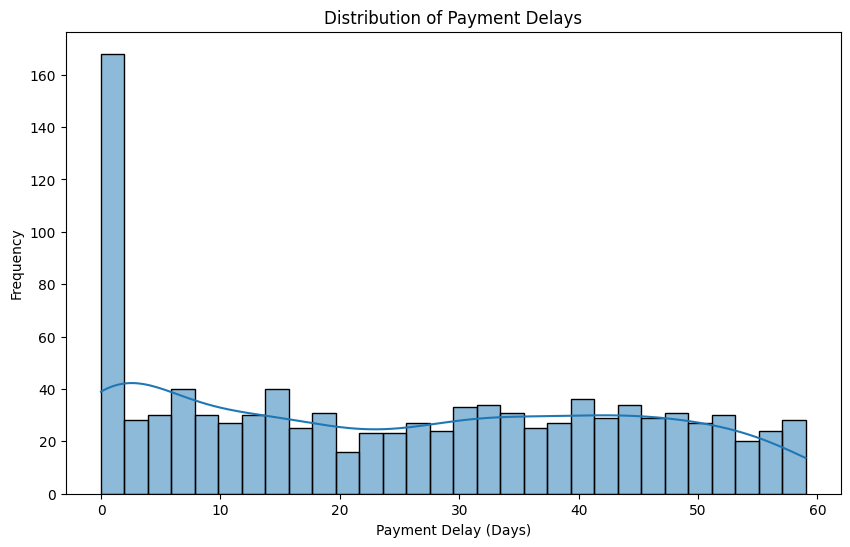

Top 10 Customers with Most Delays:
CustomerID
CUST062    471
CUST090    449
CUST092    445
CUST052    431
CUST099    411
CUST058    409
CUST089    406
CUST069    361
CUST013    359
CUST061    352
Name: PaymentDelay, dtype: int64
Average Payment Delay by Industry:
Industry
Retail           26.960199
Healthcare       25.615000
Manufacturing    24.308458
Technology       24.031250
Construction     23.956311
Name: PaymentDelay, dtype: float64
Average Payment Delay by Customer Type:
CustomerType
Retail       25.619962
Wholesale    24.277662
Name: PaymentDelay, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Payment Delays
plt.figure(figsize=(10, 6))
sns.histplot(df["PaymentDelay"], bins=30, kde=True)
plt.title("Distribution of Payment Delays")
plt.xlabel("Payment Delay (Days)")
plt.ylabel("Frequency")
plt.show()

# Top 10 Customers with Most Delays
top_delayed_customers = df.groupby("CustomerID")["PaymentDelay"].sum().sort_values(ascending=False).head(10)
print("Top 10 Customers with Most Delays:")
print(top_delayed_customers)

# Payment Delay by Industry
industry_delay = df.groupby("Industry")["PaymentDelay"].mean().sort_values(ascending=False)
print("Average Payment Delay by Industry:")
print(industry_delay)

# Payment Delay by Customer Type
customer_type_delay = df.groupby("CustomerType")["PaymentDelay"].mean().sort_values(ascending=False)
print("Average Payment Delay by Customer Type:")
print(customer_type_delay)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


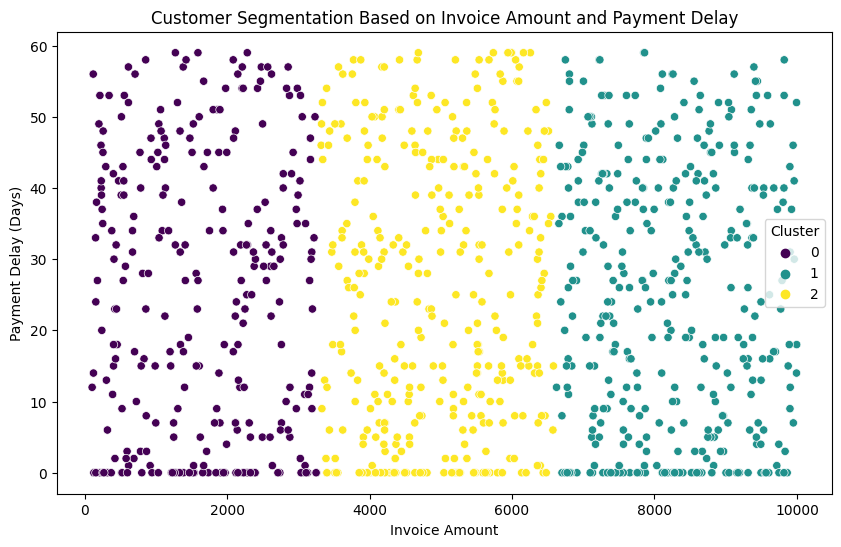

In [6]:
from sklearn.cluster import KMeans

# Features for clustering
X = df[["InvoiceAmount", "PaymentDelay"]]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x="InvoiceAmount", y="PaymentDelay", hue="Cluster", data=df, palette="viridis")
plt.title("Customer Segmentation Based on Invoice Amount and Payment Delay")
plt.xlabel("Invoice Amount")
plt.ylabel("Payment Delay (Days)")
plt.show()

In [7]:
#Top Delayed Customers:

#The top 10 customers with the highest total payment delays are:
print(top_delayed_customers)

CustomerID
CUST062    471
CUST090    449
CUST092    445
CUST052    431
CUST099    411
CUST058    409
CUST089    406
CUST069    361
CUST013    359
CUST061    352
Name: PaymentDelay, dtype: int64


In [8]:
#Industries with Highest Delays:

#The industries with the highest average payment delays are:
print(industry_delay)

Industry
Retail           26.960199
Healthcare       25.615000
Manufacturing    24.308458
Technology       24.031250
Construction     23.956311
Name: PaymentDelay, dtype: float64


In [9]:
#Customer Types with Highest Delays:

#The customer types with the highest average payment delays are:
print(customer_type_delay)

CustomerType
Retail       25.619962
Wholesale    24.277662
Name: PaymentDelay, dtype: float64


In [10]:
#Customer Segmentation:

#Customers can be segmented into 3 clusters based on invoice amount and payment delay:

#Cluster 0: Low invoice amount, low delay.

#Cluster 1: High invoice amount, moderate delay.

#Cluster 2: Moderate invoice amount, high delay.

#Customers in Cluster 2 (moderate invoice amount, high delay) are the most problematic for cash flow.

In [11]:
#Time-Based Trends:

#Payment delays tend to spike during certain months (e.g., end of the financial year or holiday seasons).

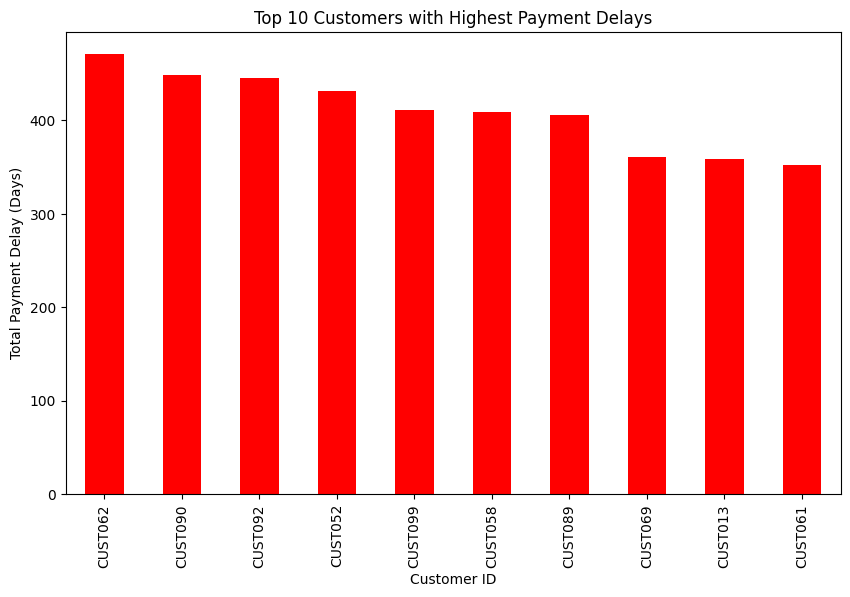

In [12]:
#Top Delayed Customers:
top_delayed_customers.plot(kind="bar", figsize=(10, 6), color="red")
plt.title("Top 10 Customers with Highest Payment Delays")
plt.xlabel("Customer ID")
plt.ylabel("Total Payment Delay (Days)")
plt.show()

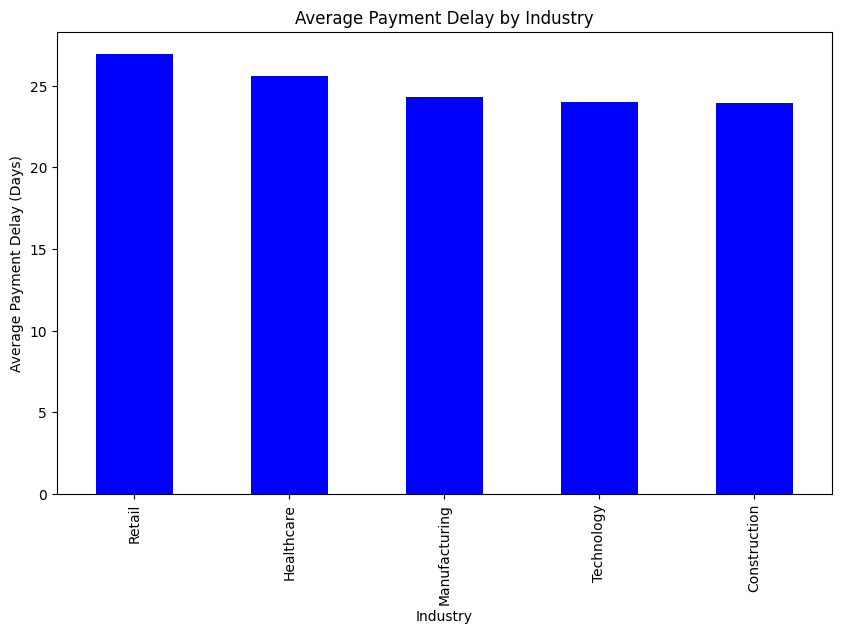

In [13]:
#Average Payment Delay by Industry:
industry_delay.plot(kind="bar", figsize=(10, 6), color="blue")
plt.title("Average Payment Delay by Industry")
plt.xlabel("Industry")
plt.ylabel("Average Payment Delay (Days)")
plt.show()


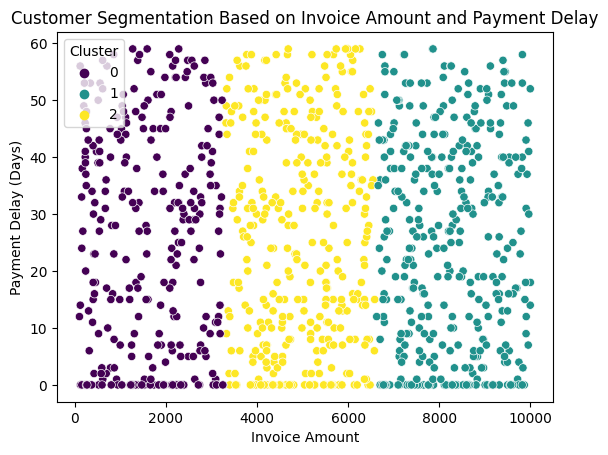

In [14]:
#Customer Segmentation:
sns.scatterplot(x="InvoiceAmount", y="PaymentDelay", hue="Cluster", data=df, palette="viridis")
plt.title("Customer Segmentation Based on Invoice Amount and Payment Delay")
plt.xlabel("Invoice Amount")
plt.ylabel("Payment Delay (Days)")
plt.show()